# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

# Visualizaton
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_palette(sns.color_palette("viridis"))

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# ML - for BERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim import AdamW

# **Load Data**

In [ ]:
df = pd.read_csv('/content/Emotion_classify_Data.csv')
df.columns = [c.lower() for c in df.columns]

# Print dataset statistics
print('\n\n___________Df Info:\n')
print(df.info())
print('\n\n___________Descriptive statistics:\n',df.describe(),'\n\n')
print('\n\n___________Number of duplicated rows:  ', df.duplicated().sum(),'\n\n')

# Look at the example of data
df.head()



___________Df Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5937 non-null   object
 1   emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB
None


___________Descriptive statistics:
                                                   comment emotion
count                                                5937    5937
unique                                               5934       3
top     i feel pretty tortured because i work a job an...   anger
freq                                                    2    2000 




___________Number of duplicated rows:   0 




,comment,emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


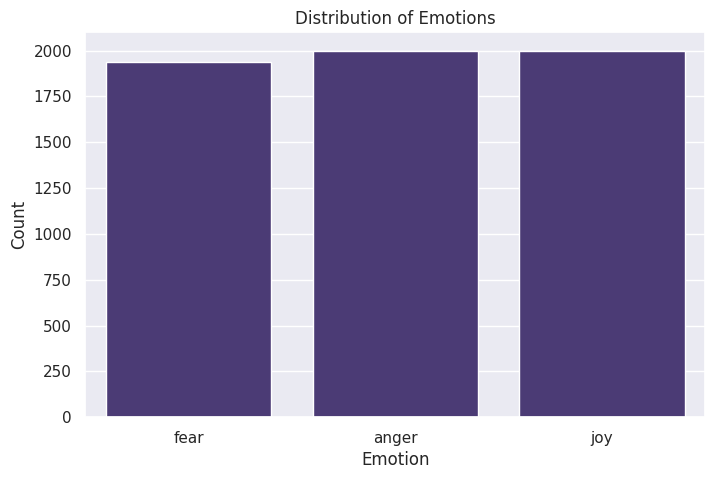

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [ ]:
# Tokenize and format the data
def preprocess_text(text):
    doc = nlp(text)
    words = []
    for w in doc:
        if w.is_stop or w.is_punct:
            continue
        words.append(w.lemma_)
    return " ".join(words)
df['comment_preprocessed'] = df['comment'].progress_apply(preprocess_text)

# Encode target variable
df['emotion_encoded'] = df['emotion'].map({'joy' : 0, 'fear': 1, 'anger': 2})

# Split the data into training and testing sets
X = df['comment_preprocessed']
y = df['emotion_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Vectorize text
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Baseline model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vectorized, y_train)
y_pred = naive_bayes.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
classification_report_nb_base = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_nb_base)

100%|██████████| 5937/5937 [00:40<00:00, 145.21it/s]

Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       400
           1       0.90      0.90      0.90       388
           2       0.90      0.92      0.91       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



In [ ]:
# Searching for best `alpha` hyperporameter

naive_bayes = MultinomialNB()
param_grid = {'alpha': np.linspace(0.1, 1.5, 15)}
grid_search = GridSearchCV(naive_bayes, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Naive Bayes classifier with the best alpha
best_naive_bayes = MultinomialNB(alpha=best_alpha)
best_naive_bayes.fit(X_train_vectorized, y_train)

# Predictions on the test set
y_pred = best_naive_bayes.predict(X_test_vectorized)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
classification_report_nb_best = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_nb_best)

Best alpha: 1.0999999999999999
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       400
           1       0.90      0.90      0.90       388
           2       0.90      0.91      0.90       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



In [ ]:
y = df['emotion']

# Convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['comment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Random Forest classifier
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
classification_report_rf_base = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_rf_base)

Accuracy: 0.93
              precision    recall  f1-score   support

       anger       0.93      0.92      0.92       497
        fear       0.94      0.91      0.93       505
         joy       0.91      0.96      0.93       483

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485



In [ ]:
# Create a Random Forest classifier
random_forest = RandomForestClassifier()

### UNCOMMENT to prerform hyperparameter search

# Define the hyperparameter grid to search
# param_grid = {
#    'n_estimators': [50, 100, 150],
#    'max_depth': [None, 10, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
# }

# Grid search with cross-validation
# grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# Best hyperparameters
# best_params = grid_search.best_params_
# print(f"Best Hyperparameters: {best_params}")

best_params = {'min_samples_leaf': 2,
               'max_depth': None,
               'min_samples_split': 2,
               'n_estimators': 150}

# Train the Random Forest classifier with the best hyperparameters
best_random_forest = RandomForestClassifier(**best_params)
best_random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = best_random_forest.predict(X_test)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
classification_report_rf_best = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_rf_best)

Accuracy: 0.93
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       497
        fear       0.96      0.91      0.94       505
         joy       0.91      0.96      0.93       483

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485



### Check if CUDA is available

In [ ]:
# Check for cuda
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print('device_count: ', torch.cuda.device_count())
print('device_name: ', torch.cuda.get_device_name(0))
print('cuda is available: ', torch.cuda.is_available())

# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

0
device_count:  1
device_name:  Tesla T4
cuda is available:  True
Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# Split the data into training and testing sets using origianl data
X = df['comment']
y = df['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to category data type
y_train = y_train.astype('category')
y_test = y_test.astype('category')

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(y_train.cat.categories))

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function
criterion = nn.CrossEntropyLoss()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize and format the data
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='pt')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt')

y_train_encodings = torch.tensor(y_train.cat.codes.values)
y_test_encodings = torch.tensor(y_test.cat.codes.values)

# Create DataLoader for efficient batch processing
train_dataset = TensorDataset(X_train_encodings['input_ids'], X_train_encodings['attention_mask'], y_train_encodings)
test_dataset = TensorDataset(X_test_encodings['input_ids'], X_test_encodings['attention_mask'], y_test_encodings)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Training BERT Model

In [ ]:
# num_epoch = 1

# for epoch in range(num_epoch):
#     print('epoch number: ',epoch)
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_dataloader):
#         input_ids, attention_mask, labels = batch
#         optimizer.zero_grad()
#         output = model(input_ids, attention_mask=attention_mask)
#         logits = output.logits

#         # Convert labels to torch.Long data type
#         labels = labels.long()

#         # CrossEntropy Loss
#         loss = criterion(logits, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     average_loss = total_loss / len(train_dataloader)
#     print(f"Epoch {epoch + 1}, Loss: {average_loss:.4f}")

### BERT Model Evaluation

In [ ]:
# model.eval()
# predictions = []
# true_labels = []

# for batch in tqdm(test_dataloader):
#     input_ids, attention_mask, labels = batch
#     with torch.no_grad():
#         output = model(input_ids, attention_mask=attention_mask)
#     predicted_labels = torch.argmax(output.logits, dim=1)
#     predictions.extend(predicted_labels.tolist())
#     true_labels.extend(labels.tolist())

# # Decode labels to original classes
# predicted_emotions = y_train.cat.categories[predictions]
# true_emotions = y_train.cat.categories[true_labels]

# # Evaluate model
# accuracy = accuracy_score(true_emotions, predicted_emotions)
# classification_report_bert = classification_report(true_emotions, predicted_emotions)

# print(f'Accuracy: {accuracy:.2f}')
# print(classification_report_bert)

In [ ]:
#torch.save(model.state_dict(), 'emotion_detection_model.pth')

In [ ]:
import time


In [ ]:
start_time = time.time()
# Use the fitted model from the grid search
y_pred_nb = best_naive_bayes.predict(X_test_vectorized)
inference_time_nb = time.time() - start_time

print(f"Naive Bayes Inference Time: {inference_time_nb:.4f} seconds")

Naive Bayes Inference Time: 0.0009 seconds


In [ ]:
start_time = time.time()
# Use the fitted model from the grid search
# y_pred_rf = random_forest.predict(X_test) # This was the unfitted model

# Transform X_test using the same vectorizer used for training
X_test_vectorized_rf = vectorizer.transform(X_test)

# Use the best_random_forest model with the vectorized test data
y_pred_rf = best_random_forest.predict(X_test_vectorized_rf)

inference_time_rf = time.time() - start_time

print(f"Random Forest Inference Time: {inference_time_rf:.4f} seconds")

Random Forest Inference Time: 0.0752 seconds


In [ ]:
# # Move the model to the specified device
# model.to(device)

# model.eval()
# all_preds = []
# start_time = time.time()
# with torch.no_grad():
#     for batch in test_dataloader:
#         input_ids, attention_mask, labels = batch
#         # Move input tensors and labels to the same device
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device) # Move labels to the device

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = outputs.logits.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
# inference_time_bert = time.time() - start_time

# print(f"BERT Inference Time: {inference_time_bert:.4f} seconds")

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_palette(sns.color_palette("viridis"))

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# NLP / spaCy
import spacy
nlp = spacy.load("en_core_web_sm")

# PyTorch & Transformers
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    pipeline
)

# TensorFlow Keras for bi-LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

import time

# === Load & preprocess ===
df = pd.read_csv('/content/Emotion_classify_Data.csv')
df.columns = [c.lower() for c in df.columns]

# basic info
print(df.info())
print("Duplicates:", df.duplicated().sum())

# preprocess with spaCy
def preprocess_text(text):
    doc = nlp(text)
    return " ".join(w.lemma_ for w in doc if not (w.is_stop or w.is_punct))

df['comment_pp'] = df['comment'].progress_apply(preprocess_text)
df['label'] = df['emotion'].map({'joy':0,'fear':1,'anger':2})

# train/test split
X = df['comment_pp']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 1) TF-IDF vectorization ===
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# -- 1a) Naive Bayes (with hyperparam search) --
nb = MultinomialNB()
params = {'alpha': np.linspace(0.1,1.5,15)}
gs = GridSearchCV(nb, params, cv=5, scoring='accuracy')
gs.fit(X_train_tfidf, y_train)
best_nb = gs.best_estimator_

start = time.time()
y_nb = best_nb.predict(X_test_tfidf)
t_nb = time.time() - start

print("NB accuracy:", accuracy_score(y_test, y_nb))
print(classification_report(y_test, y_nb))
print(f"NB inference time: {t_nb:.4f}s\n")

# -- 1b) Random Forest --
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=2,
                            random_state=42)
rf.fit(X_train_tfidf, y_train)

start = time.time()
y_rf = rf.predict(X_test_tfidf)
t_rf = time.time() - start

print("RF accuracy:", accuracy_score(y_test, y_rf))
print(classification_report(y_test, y_rf))
print(f"RF inference time: {t_rf:.4f}s\n")

# -- 1c) SVM (linear) --
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

start = time.time()
y_svm = svm.predict(X_test_tfidf)
t_svm = time.time() - start

print("SVM accuracy:", accuracy_score(y_test, y_svm))
print(classification_report(y_test, y_svm))
print(f"SVM inference time: {t_svm:.4f}s\n")

# === 2) bi-LSTM with Keras ===
max_words = 10_000
max_len   = 100

tk = Tokenizer(num_words=max_words)
tk.fit_on_texts(df['comment_pp'])
seqs = tk.texts_to_sequences(df['comment_pp'])
X_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
y_seq = df['label'].values

X_tr_seq, X_te_seq, y_tr_seq, y_te_seq = train_test_split(
    X_pad, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

model_bi = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model_bi.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_bi.fit(
    X_tr_seq, y_tr_seq,
    epochs=3, batch_size=32,
    validation_split=0.1,
    verbose=1
)

start = time.time()
probs_bi = model_bi.predict(X_te_seq, batch_size=32)
t_bi = time.time() - start
y_bi = probs_bi.argmax(axis=1)

print("biLSTM accuracy:", accuracy_score(y_te_seq, y_bi))
print(classification_report(y_te_seq, y_bi))
print(f"biLSTM inference time: {t_bi:.4f}s\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5937 non-null   object
 1   emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB
None
Duplicates: 0


100%|██████████| 5937/5937 [00:56<00:00, 106.01it/s]


NB accuracy: 0.9006734006734006
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       400
           1       0.90      0.90      0.90       388
           2       0.90      0.91      0.90       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188

NB inference time: 0.0004s

RF accuracy: 0.9158249158249159
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       400
           1       0.92      0.93      0.92       388
           2       0.95      0.86      0.91       400

    accuracy                           0.92      1188
   macro avg       0.92      0.92      0.92      1188
weighted avg       0.92      0.92      0.92      1188

RF inference time: 0.0680s

SVM accuracy: 0.9276094276094277
              precision    recall  f1-score   support

           0       0.91      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT-base accuracy: 0.3367003367003367
BERT-base inference time: 2.9413s



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


DistilBERT inference time: 1.4505s



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


RoBERTa inference time: 2.4157s



#FINAL

Data SEBELUM Preprocessing:
                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear



Data SETELAH Preprocessing:
                                             Comment  \
0  i seriously hate one subject to death but now ...   
1                 im so full of life i feel appalled   
2  i sit here to write i start to dig out my feel...   
3  ive been really angry with r and i feel like a...   
4  i feel suspicious if there is no one outside l...   

                                preprocessed_comment  
0    serious hate one subject death feel reluct drop  
1                            im full life feel appal  
2  sit write start dig feel think afraid accept p...  
3  ive realli angr

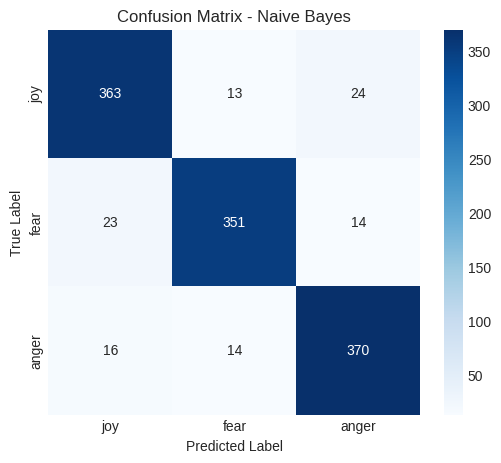

--- Evaluasi Model: SVM ---
Accuracy: 0.9259
Precision: 0.9271
Recall: 0.9259
F1-Score: 0.9259
Inference Time: 1.0481 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.89      0.96      0.93       400
        fear       0.95      0.90      0.93       388
       anger       0.94      0.92      0.93       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



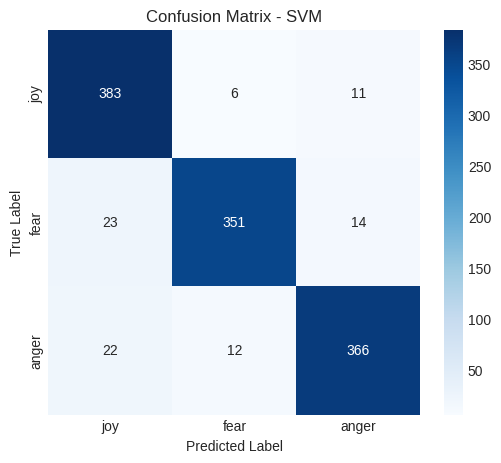

--- Evaluasi Model: Random Forest ---
Accuracy: 0.9343
Precision: 0.9351
Recall: 0.9343
F1-Score: 0.9345
Inference Time: 0.1161 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.97      0.93      0.95       400
        fear       0.91      0.95      0.93       388
       anger       0.93      0.93      0.93       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.94      0.93      0.93      1188



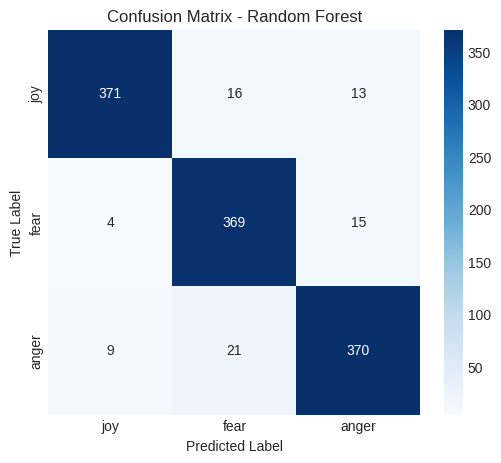


Memulai Training Deep Learning Models...



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4155 - loss: 1.0429 - val_accuracy: 0.8864 - val_loss: 0.3163
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9465 - loss: 0.1864 - val_accuracy: 0.9108 - val_loss: 0.2621
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9812 - loss: 0.0655 - val_accuracy: 0.9133 - val_loss: 0.3045
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9914 - loss: 0.0307 - val_accuracy: 0.9066 - val_loss: 0.3403
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9945 - loss: 0.0214 - val_accuracy: 0.9074 - val_loss: 0.3387
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9948 - loss: 0.0162 - val_accuracy: 0.9015 - val_loss: 0.4028
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9961 - loss: 0.0132 - val_accuracy: 0.9125 - val_loss: 0.3977
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9955 - loss: 0.0137 - val

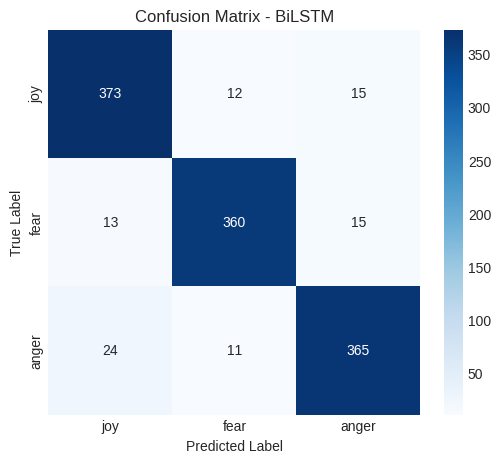

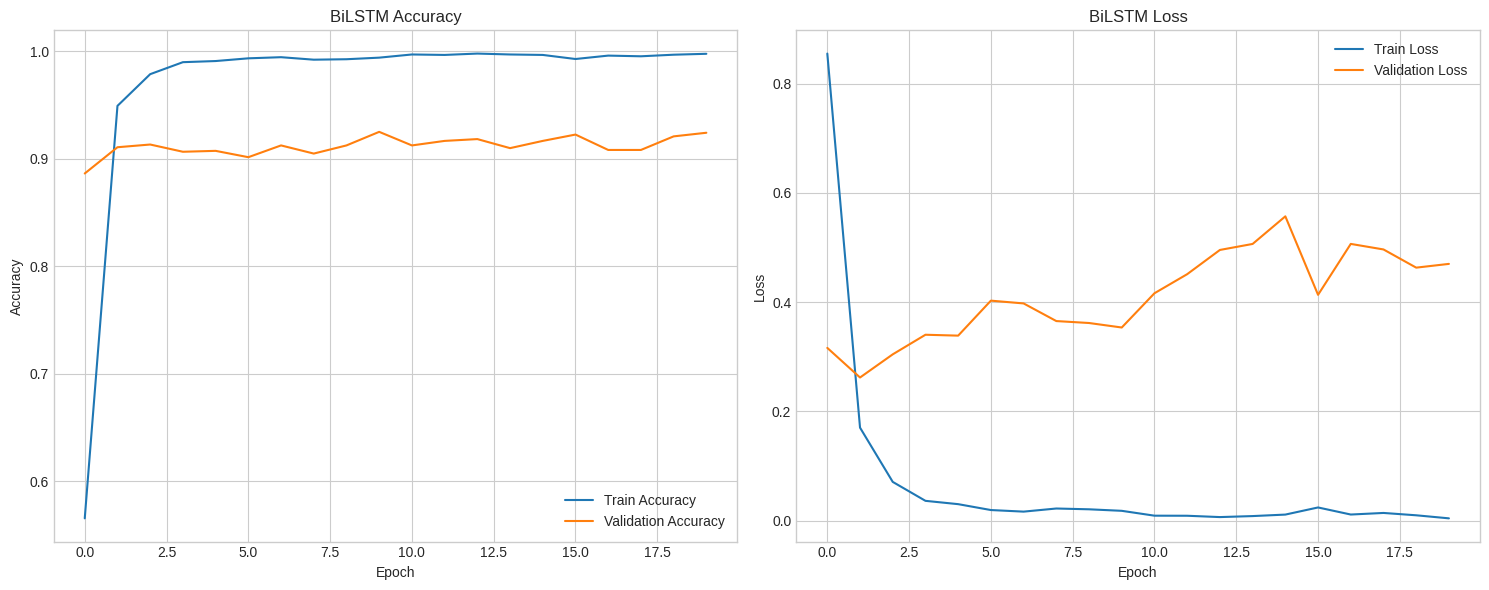

Using device: cuda

--------------------------------------------------
Training model: DistilBERT
--------------------------------------------------
Epoch 1/10 | Train Loss: 0.5471 | Train Acc: 0.7745 | Val Loss: 0.2245 | Val Acc: 0.9310
Epoch 2/10 | Train Loss: 0.1488 | Train Acc: 0.9495 | Val Loss: 0.1797 | Val Acc: 0.9394
Epoch 3/10 | Train Loss: 0.0779 | Train Acc: 0.9739 | Val Loss: 0.1782 | Val Acc: 0.9436
Epoch 4/10 | Train Loss: 0.0475 | Train Acc: 0.9827 | Val Loss: 0.1855 | Val Acc: 0.9453
Epoch 5/10 | Train Loss: 0.0417 | Train Acc: 0.9827 | Val Loss: 0.1720 | Val Acc: 0.9470
Epoch 6/10 | Train Loss: 0.0372 | Train Acc: 0.9869 | Val Loss: 0.2099 | Val Acc: 0.9394
Epoch 7/10 | Train Loss: 0.0265 | Train Acc: 0.9909 | Val Loss: 0.2140 | Val Acc: 0.9537
Epoch 8/10 | Train Loss: 0.0217 | Train Acc: 0.9901 | Val Loss: 0.2345 | Val Acc: 0.9478
Epoch 9/10 | Train Loss: 0.0247 | Train Acc: 0.9905 | Val Loss: 0.2120 | Val Acc: 0.9470
Epoch 10/10 | Train Loss: 0.0222 | Train Acc: 0.99

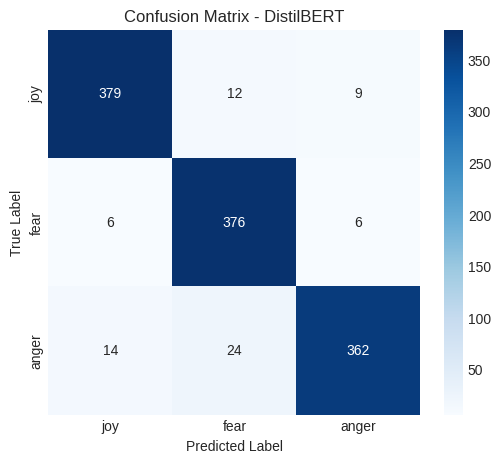

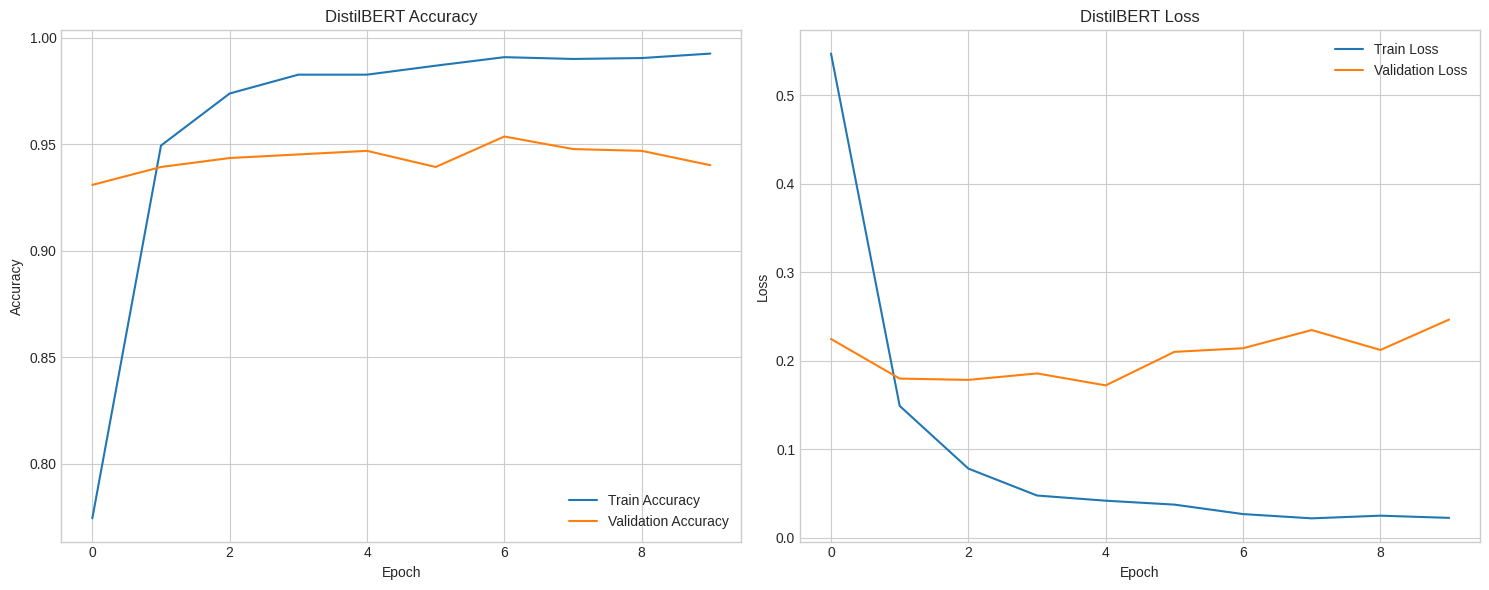


--------------------------------------------------
Training model: RoBERTa
--------------------------------------------------
Epoch 1/10 | Train Loss: 0.5569 | Train Acc: 0.7656 | Val Loss: 0.2214 | Val Acc: 0.9209
Epoch 2/10 | Train Loss: 0.1971 | Train Acc: 0.9337 | Val Loss: 0.1749 | Val Acc: 0.9318
Epoch 3/10 | Train Loss: 0.1208 | Train Acc: 0.9558 | Val Loss: 0.1511 | Val Acc: 0.9478
Epoch 4/10 | Train Loss: 0.0873 | Train Acc: 0.9680 | Val Loss: 0.1609 | Val Acc: 0.9436
Epoch 5/10 | Train Loss: 0.0731 | Train Acc: 0.9716 | Val Loss: 0.1877 | Val Acc: 0.9495
Epoch 6/10 | Train Loss: 0.0695 | Train Acc: 0.9720 | Val Loss: 0.1696 | Val Acc: 0.9503
Epoch 7/10 | Train Loss: 0.0492 | Train Acc: 0.9775 | Val Loss: 0.2383 | Val Acc: 0.9386
Epoch 8/10 | Train Loss: 0.0334 | Train Acc: 0.9840 | Val Loss: 0.1983 | Val Acc: 0.9495
Epoch 9/10 | Train Loss: 0.0469 | Train Acc: 0.9817 | Val Loss: 0.2157 | Val Acc: 0.9461
Epoch 10/10 | Train Loss: 0.0398 | Train Acc: 0.9817 | Val Loss: 0.1779 

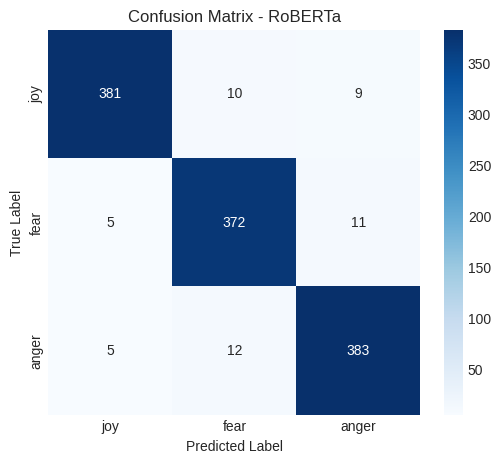

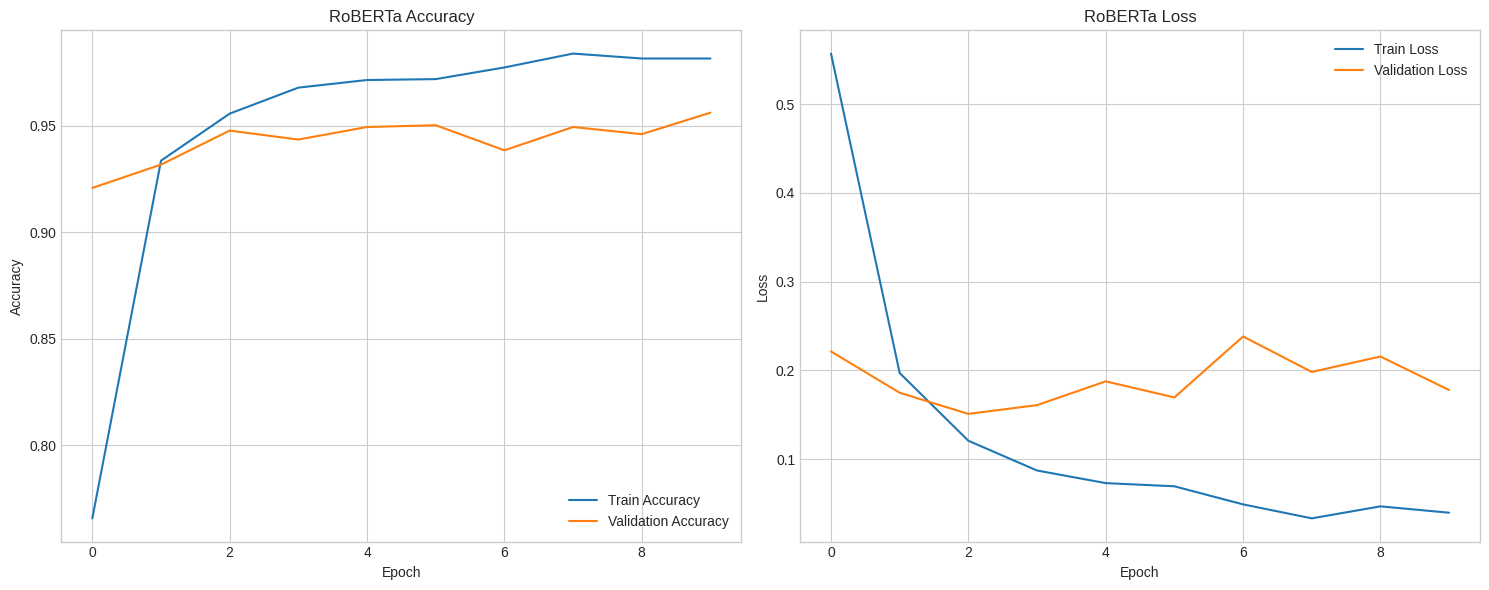


--------------------------------------------------
Training model: BERT
--------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.6190 | Train Acc: 0.7138 | Val Loss: 0.2283 | Val Acc: 0.9276
Epoch 2/10 | Train Loss: 0.1418 | Train Acc: 0.9511 | Val Loss: 0.1568 | Val Acc: 0.9478
Epoch 3/10 | Train Loss: 0.0817 | Train Acc: 0.9714 | Val Loss: 0.1636 | Val Acc: 0.9369
Epoch 4/10 | Train Loss: 0.0597 | Train Acc: 0.9770 | Val Loss: 0.2120 | Val Acc: 0.9394
Epoch 5/10 | Train Loss: 0.0416 | Train Acc: 0.9838 | Val Loss: 0.1644 | Val Acc: 0.9512
Epoch 6/10 | Train Loss: 0.0356 | Train Acc: 0.9874 | Val Loss: 0.1694 | Val Acc: 0.9529
Epoch 7/10 | Train Loss: 0.0388 | Train Acc: 0.9865 | Val Loss: 0.1835 | Val Acc: 0.9512
Epoch 8/10 | Train Loss: 0.0395 | Train Acc: 0.9859 | Val Loss: 0.2023 | Val Acc: 0.9461
Epoch 9/10 | Train Loss: 0.0283 | Train Acc: 0.9876 | Val Loss: 0.3466 | Val Acc: 0.9226
Epoch 10/10 | Train Loss: 0.0303 | Train Acc: 0.9884 | Val Loss: 0.2255 | Val Acc: 0.9478
--- Evaluasi Model: BERT ---
Accuracy: 0.9478
Precision: 0.9491
Recall: 0.9478
F1-Score: 0.9479
Inference Tim

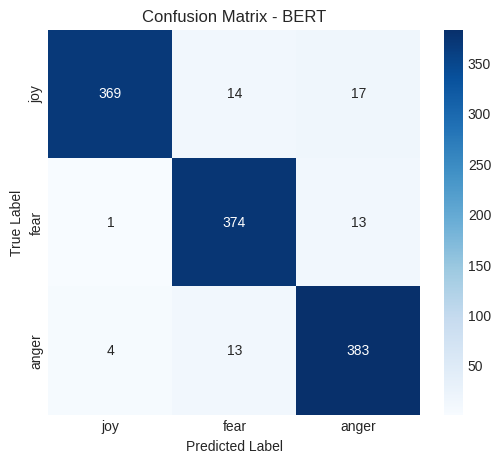

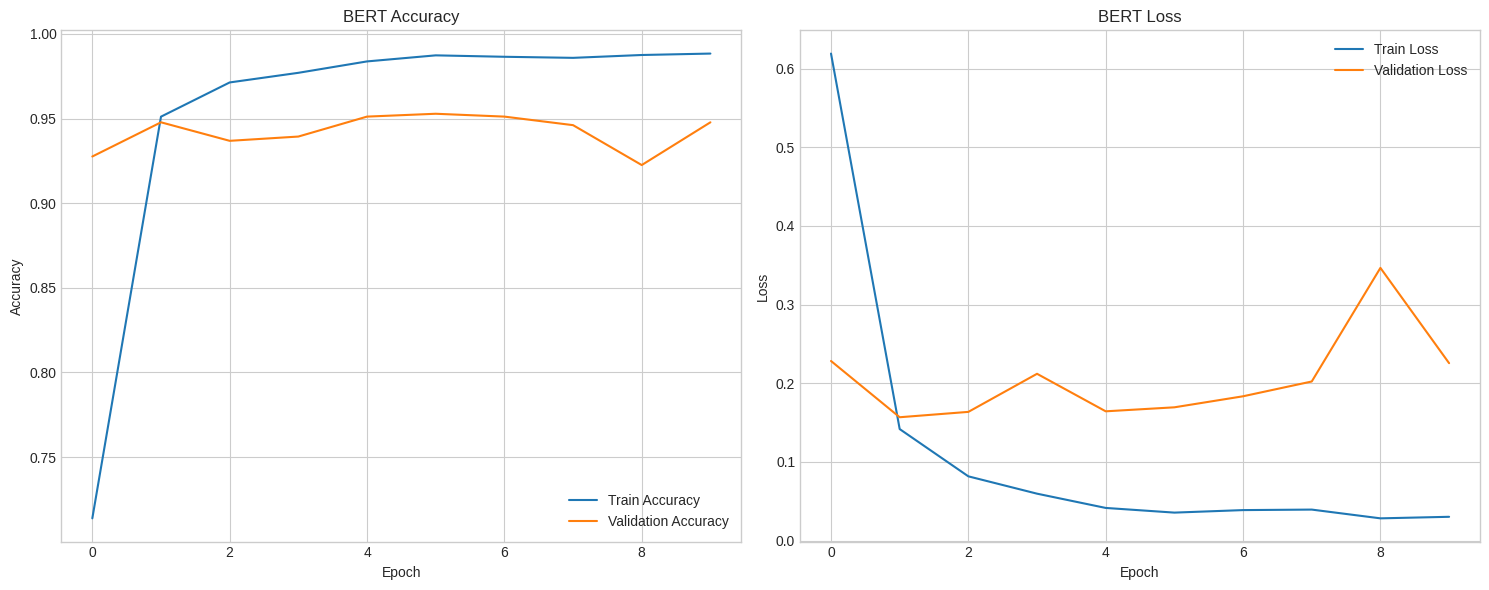


Ringkasan Hasil Semua Model

               Accuracy  Precision    Recall  F1-Score  Inference Time (s)
RoBERTa        0.956229   0.956443  0.956229  0.956271            3.100860
BERT           0.947811   0.949051  0.947811  0.947903            3.936949
DistilBERT     0.940236   0.941188  0.940236  0.940160            1.993568
Random Forest  0.934343   0.935150  0.934343  0.934456            0.116061
SVM            0.925926   0.927139  0.925926  0.925945            1.048121
BiLSTM         0.924242   0.924430  0.924242  0.924264            0.977806
Naive Bayes    0.912458   0.912647  0.912458  0.912469            0.002009


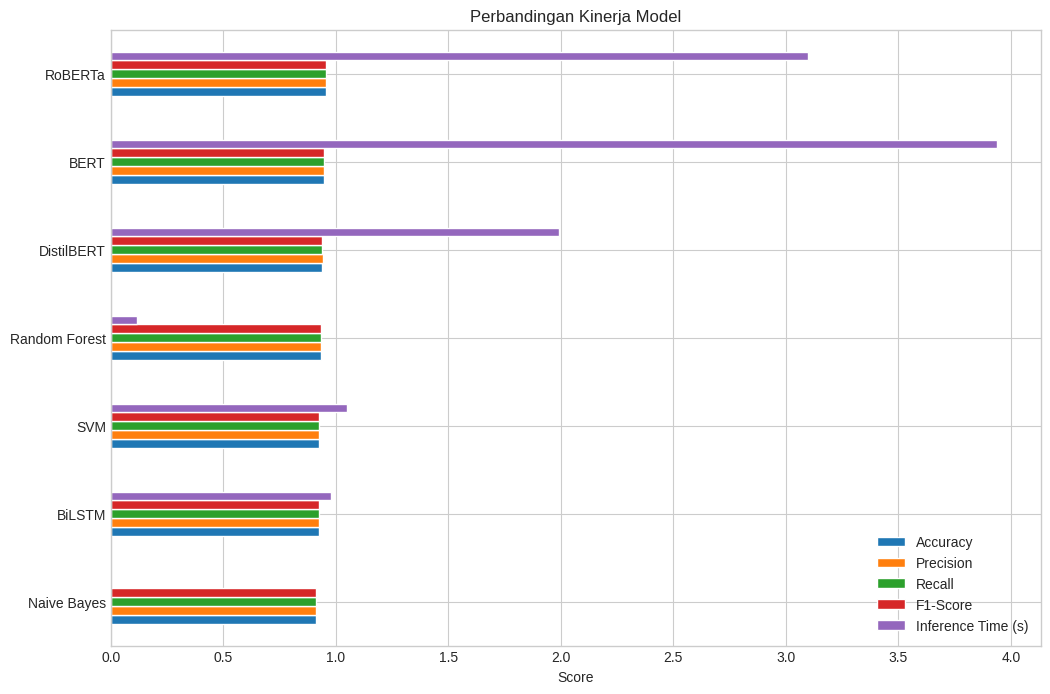

In [ ]:
# ==============================================================================
# 1. IMPORT LIBRARIES
# ==============================================================================
import numpy as np
import pandas as pd
import time
import re
from unicodedata import normalize
import warnings

# NLTK for preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from torch.optim import AdamW

# TensorFlow / Keras for Deep Learning (BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# PyTorch & Transformers for Deep Learning (BERT, RoBERTa, DistilBERT)
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    logging as hf_logging
)

# ==============================================================================
# INITIAL SETUP
# ==============================================================================
# Suppress warnings
warnings.filterwarnings('ignore')
hf_logging.set_verbosity_error() # Suppress transformers warnings

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")


# Download NLTK data (only need to run once)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    print("Download complete.")

# ==============================================================================
# 2. DATA LOADING & PREPROCESSING
# ==============================================================================
# Load dataset
try:
    df = pd.read_csv('Emotion_classify_Data.csv')
except FileNotFoundError:
    print("Pastikan file 'Emotion_classify_Data.csv' berada di direktori yang sama.")
    # Create a dummy dataframe for demonstration if file not found
    data = {'Comment': ["I am so happy and joyful today!",
                        "This is a very scary movie, I am afraid.",
                        "I am so angry at him for what he did.",
                        "i feel so good and amazing",
                        "this is horrible i hate it so much"],
            'Emotion': ['joy', 'fear', 'anger', 'joy', 'anger']}
    df = pd.DataFrame(data)
    df.columns = [c.lower() for c in df.columns]

# Your provided preprocessing function
def preprocessing(text: str) -> str:
    """
    This function takes raw text as input and performs a series of preprocessing steps.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w != 'rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# --- DEBUG: Show data before preprocessing ---
print("="*50)
print("Data SEBELUM Preprocessing:")
print("="*50)
print(df.head())
print("\n" * 2)

# Apply preprocessing
df['preprocessed_comment'] = df['Comment'].apply(preprocessing)

# --- DEBUG: Show data after preprocessing ---
print("="*50)
print("Data SETELAH Preprocessing:")
print("="*50)
print(df[['Comment', 'preprocessed_comment']].head())
print("\n" * 2)

# Encode labels
emotion_map = {'joy': 0, 'fear': 1, 'anger': 2}
df['label'] = df['Emotion'].map(emotion_map)
id2label = {v: k for k, v in emotion_map.items()}
num_labels = len(emotion_map)

# ==============================================================================
# 3. DATA SPLITTING & DISTRIBUTION CHECK
# ==============================================================================
X = df['preprocessed_comment']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- DEBUG: Show emotion distribution after splitting ---
print("="*50)
print("Distribusi Emosi Setelah Splitting (80:20):")
print("="*50)
print("\nDistribusi Data Training:")
print(y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\nDistribusi Data Testing:")
print(y_test.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\n" * 2)

# Store all model results for final comparison
results = {}

# Helper function for evaluation
def evaluate_model(name, y_true, y_pred, y_prob, inference_time, history=None):
    """
    Mengevaluasi model, menampilkan metrik, dan memvisualisasikan hasil.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Inference Time (s)': inference_time
    }

    print(f"--- Evaluasi Model: {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_map.keys()))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ==================================================================
    # BAGIAN YANG DIUBAH: Penambahan nama model pada judul grafik
    # ==================================================================
    if history:
        # Membuat figure dengan dua plot berdampingan
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Accuracy
        ax1.plot(history.history['accuracy'], label='Train Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        # Judul diubah untuk menyertakan nama model
        ax1.set_title(f'{name} Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend(loc='lower right')
        ax1.grid(True)

        # Plot 2: Loss
        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        # Judul diubah untuk menyertakan nama model
        ax2.set_title(f'{name} Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend(loc='upper right')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

# ==============================================================================
# 4. MACHINE LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Machine Learning Models...")
print("="*50 + "\n")

# --- Feature Extraction: TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_nb = nb_model.predict(X_test_tfidf)
y_prob_nb = nb_model.predict_proba(X_test_tfidf)
inference_time_nb = time.time() - start_time
evaluate_model('Naive Bayes', y_test, y_pred_nb, y_prob_nb, inference_time_nb)

# --- SVM ---
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_svm = svm_model.predict(X_test_tfidf)
y_prob_svm = svm_model.predict_proba(X_test_tfidf)
inference_time_svm = time.time() - start_time
evaluate_model('SVM', y_test, y_pred_svm, y_prob_svm, inference_time_svm)

# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)
inference_time_rf = time.time() - start_time
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf, inference_time_rf)


# ==============================================================================
# 5. DEEP LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Deep Learning Models...")
print("="*50 + "\n")

# --- BiLSTM ---
# Hyperparameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
MAX_LEN = 128
EPOCHS_BILSTM = 20
LR_BILSTM = 1e-3

# Tokenization and Padding
tokenizer_keras = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_keras.fit_on_texts(X_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Model Definition
bilstm_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

bilstm_model.compile(
    optimizer=Adam(learning_rate=LR_BILSTM),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(bilstm_model.summary())

history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_BILSTM,
    validation_data=(X_test_pad, y_test),
    batch_size=32,
    verbose=1
)

start_time = time.time()
y_prob_bilstm = bilstm_model.predict(X_test_pad)
inference_time_bilstm = time.time() - start_time
y_pred_bilstm = np.argmax(y_prob_bilstm, axis=1)
evaluate_model('BiLSTM', y_test, y_pred_bilstm, y_prob_bilstm, inference_time_bilstm, history_bilstm)


# --- TRANSFORMER MODELS (BERT, RoBERTa, DistilBERT) ---
# Hyperparameters
MAX_LEN_HF = 128
BATCH_SIZE_HF = 16
EPOCHS_HF = 10
LR_HF = 2e-5

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Models to train
transformer_models = {
    'DistilBERT': 'distilbert-base-uncased',
    'RoBERTa': 'roberta-base',
    'BERT': 'bert-base-uncased'
}

# Convert text data to list for tokenizer
X_train_list = X_train.tolist()
X_test_list = y_test.tolist()

for model_name, model_path in transformer_models.items():
    print("\n" + "-"*50)
    print(f"Training model: {model_name}")
    print("-" * 50)

    # Load Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        id2label=id2label,
        label2id=emotion_map
    ).to(device)

    # Tokenize data
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')

    # Create PyTorch Datasets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_HF, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_HF, shuffle=False)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=LR_HF)

    # Training and Validation History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_HF):
        model.train()
        total_train_loss, total_train_correct = 0, 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels).sum().item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = total_train_correct / len(train_dataset)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        total_val_loss, total_val_correct = 0, 0
        with torch.no_grad():
            for batch in test_loader:
                batch = [t.to(device) for t in batch]
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                total_val_correct += (preds == labels).sum().item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_acc = total_val_correct / len(test_dataset)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_HF} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Final Evaluation on Test Set
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time_hf = time.time() - start_time

    # Plotting custom history for transformers
    history_df = pd.DataFrame({
        'loss': history['train_loss'],
        'accuracy': history['train_acc'],
        'val_loss': history['val_loss'],
        'val_accuracy': history['val_acc'],
    })

    # Passing a dummy history object to the evaluation function
    class DummyHistory:
        def __init__(self, df):
            self.history = df.to_dict('list')

    evaluate_model(model_name, all_labels, all_preds, None, inference_time_hf, DummyHistory(history_df))

# ==============================================================================
# 6. FINAL RESULTS SUMMARY
# ==============================================================================
print("\n" + "="*50)
print("Ringkasan Hasil Semua Model")
print("="*50 + "\n")

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='F1-Score', ascending=False))

# Plotting final results for comparison
results_df.sort_values(by='F1-Score', ascending=True).plot(
    kind='barh',
    figsize=(12, 8),
    title='Perbandingan Kinerja Model',
    grid=True
)
plt.xlabel("Score")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# ==============================================================================
# 1. IMPORT LIBRARIES
# ==============================================================================
import numpy as np
import pandas as pd
import time
import re
from unicodedata import normalize
import warnings

# NLTK for preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from torch.optim import AdamW

# TensorFlow / Keras for Deep Learning (BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# PyTorch & Transformers for Deep Learning (BERT, RoBERTa, DistilBERT)
import torch
import transformers
from torch.utils.data import TensorDataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    logging as hf_logging
)

# ==============================================================================
# INITIAL SETUP
# ==============================================================================
# Suppress warnings
warnings.filterwarnings('ignore')
hf_logging.set_verbosity_error() # Suppress transformers warnings

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")


# Download NLTK data (only need to run once)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    print("Download complete.")

print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
# ==============================================================================
# 2. DATA LOADING & PREPROCESSING
# ==============================================================================
# Load dataset
try:
    df = pd.read_csv('Emotion_classify_Data.csv')
except FileNotFoundError:
    print("Pastikan file 'Emotion_classify_Data.csv' berada di direktori yang sama.")
    # Create a dummy dataframe for demonstration if file not found
    data = {'Comment': ["I am so happy and joyful today!",
                        "This is a very scary movie, I am afraid.",
                        "I am so angry at him for what he did.",
                        "i feel so good and amazing",
                        "this is horrible i hate it so much"],
            'Emotion': ['joy', 'fear', 'anger', 'joy', 'anger']}
    df = pd.DataFrame(data)
    df.columns = [c.lower() for c in df.columns]

# Your provided preprocessing function
def preprocessing(text: str) -> str:
    """
    This function takes raw text as input and performs a series of preprocessing steps.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w != 'rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# --- DEBUG: Show data before preprocessing ---
print("="*50)
print("Data SEBELUM Preprocessing:")
print("="*50)
print(df.head())
print("\n" * 2)

# Apply preprocessing
df['preprocessed_comment'] = df['Comment'].apply(preprocessing)

# --- DEBUG: Show data after preprocessing ---
print("="*50)
print("Data SETELAH Preprocessing:")
print("="*50)
print(df[['Comment', 'preprocessed_comment']].head())
print("\n" * 2)

# Encode labels
emotion_map = {'joy': 0, 'fear': 1, 'anger': 2}
df['label'] = df['Emotion'].map(emotion_map)
id2label = {v: k for k, v in emotion_map.items()}
num_labels = len(emotion_map)

# ==============================================================================
# 3. DATA SPLITTING & DISTRIBUTION CHECK
# ==============================================================================
X = df['preprocessed_comment']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- DEBUG: Show emotion distribution after splitting ---
print("="*50)
print("Distribusi Emosi Setelah Splitting (80:20):")
print("="*50)

# Mengganti nama label dari angka ke nama emosi untuk keterbacaan
train_distribution = y_train.map(id2label).value_counts()
test_distribution = y_test.map(id2label).value_counts()

print("\nJumlah Emosi pada Data Training:")
print(train_distribution)
print("\nJumlah Emosi pada Data Testing:")
print(test_distribution)
print("\n" * 2)

# Store all model results for final comparison
results = {}

# Helper function for evaluation
def evaluate_model(name, y_true, y_pred, y_prob, inference_time, history=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Inference Time (s)': inference_time
    }

    print(f"--- Evaluasi Model: {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_map.keys()))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot Training History for Deep Learning models
    if history:
        pd.DataFrame(history.history).plot(figsize=(10, 6))
        plt.grid(True)
        plt.gca().set_ylim(0, 1.1)
        plt.title(f'Training & Validation Metrics - {name}')
        plt.show()

# ==============================================================================
# 4. MACHINE LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Machine Learning Models...")
print("="*50 + "\n")

# --- Feature Extraction: TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_nb = nb_model.predict(X_test_tfidf)
y_prob_nb = nb_model.predict_proba(X_test_tfidf)
inference_time_nb = time.time() - start_time
evaluate_model('Naive Bayes', y_test, y_pred_nb, y_prob_nb, inference_time_nb)

# --- SVM ---
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_svm = svm_model.predict(X_test_tfidf)
y_prob_svm = svm_model.predict_proba(X_test_tfidf)
inference_time_svm = time.time() - start_time
evaluate_model('SVM', y_test, y_pred_svm, y_prob_svm, inference_time_svm)

# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)
inference_time_rf = time.time() - start_time
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf, inference_time_rf)


# ==============================================================================
# 5. DEEP LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Deep Learning Models...")
print("="*50 + "\n")

# --- BiLSTM ---
# Hyperparameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
MAX_LEN = 128
EPOCHS_BILSTM = 20
LR_BILSTM = 1e-3

# Tokenization and Padding
tokenizer_keras = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_keras.fit_on_texts(X_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Model Definition
bilstm_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

bilstm_model.compile(
    optimizer=Adam(learning_rate=LR_BILSTM),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(bilstm_model.summary())

history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_BILSTM,
    validation_data=(X_test_pad, y_test),
    batch_size=32,
    verbose=1
)

start_time = time.time()
y_prob_bilstm = bilstm_model.predict(X_test_pad)
inference_time_bilstm = time.time() - start_time
y_pred_bilstm = np.argmax(y_prob_bilstm, axis=1)
evaluate_model('BiLSTM', y_test, y_pred_bilstm, y_prob_bilstm, inference_time_bilstm, history_bilstm)


# --- TRANSFORMER MODELS (BERT, RoBERTa, DistilBERT) ---
# Hyperparameters
MAX_LEN_HF = 128
BATCH_SIZE_HF = 16
EPOCHS_HF = 10
LR_HF = 2e-5

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Models to train
transformer_models = {
    'DistilBERT': 'distilbert-base-uncased',
    'RoBERTa': 'roberta-base',
    'BERT': 'bert-base-uncased'
}

# Convert text data to list for tokenizer
X_train_list = X_train.tolist()
X_test_list = y_test.tolist()

for model_name, model_path in transformer_models.items():
    print("\n" + "-"*50)
    print(f"Training model: {model_name}")
    print("-" * 50)

    # Load Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        id2label=id2label,
        label2id=emotion_map
    ).to(device)

    # Tokenize data
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')

    # Create PyTorch Datasets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_HF, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_HF, shuffle=False)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=LR_HF)

    # Training and Validation History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_HF):
        model.train()
        total_train_loss, total_train_correct = 0, 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels).sum().item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = total_train_correct / len(train_dataset)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        total_val_loss, total_val_correct = 0, 0
        with torch.no_grad():
            for batch in test_loader:
                batch = [t.to(device) for t in batch]
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                total_val_correct += (preds == labels).sum().item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_acc = total_val_correct / len(test_dataset)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_HF} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Final Evaluation on Test Set
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time_hf = time.time() - start_time

    # Plotting custom history for transformers
    history_df = pd.DataFrame({
        'loss': history['train_loss'],
        'accuracy': history['train_acc'],
        'val_loss': history['val_loss'],
        'val_accuracy': history['val_acc'],
    })

    # Passing a dummy history object to the evaluation function
    class DummyHistory:
        def __init__(self, df):
            self.history = df.to_dict('list')

    evaluate_model(model_name, all_labels, all_preds, None, inference_time_hf, DummyHistory(history_df))

# ==============================================================================
# 6. FINAL RESULTS SUMMARY
# ==============================================================================
print("\n" + "="*50)
print("Ringkasan Hasil Semua Model")
print("="*50 + "\n")

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='F1-Score', ascending=False))

# Plotting final results for comparison
results_df.sort_values(by='F1-Score', ascending=True).plot(
    kind='barh',
    figsize=(12, 8),
    title='Perbandingan Kinerja Model',
    grid=True
)
plt.xlabel("Score")
plt.legend(loc='lower right')
plt.show()

PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0
Transformers version: 4.53.1
Scikit-learn version: 1.6.1
Pandas version: 2.2.2
NumPy version: 2.0.2
Pastikan file 'Emotion_classify_Data.csv' berada di direktori yang sama.
Data SEBELUM Preprocessing:
                                    comment emotion
0           I am so happy and joyful today!     joy
1  This is a very scary movie, I am afraid.    fear
2     I am so angry at him for what he did.   anger
3                i feel so good and amazing     joy
4        this is horrible i hate it so much   anger





KeyError: 'Comment'

#debug tfidf

Data SEBELUM Preprocessing:
                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear



Data SETELAH Preprocessing:
                                             Comment  \
0  i seriously hate one subject to death but now ...   
1                 im so full of life i feel appalled   
2  i sit here to write i start to dig out my feel...   
3  ive been really angry with r and i feel like a...   
4  i feel suspicious if there is no one outside l...   

                                preprocessed_comment  
0    serious hate one subject death feel reluct drop  
1                            im full life feel appal  
2  sit write start dig feel think afraid accept p...  
3  ive realli angr

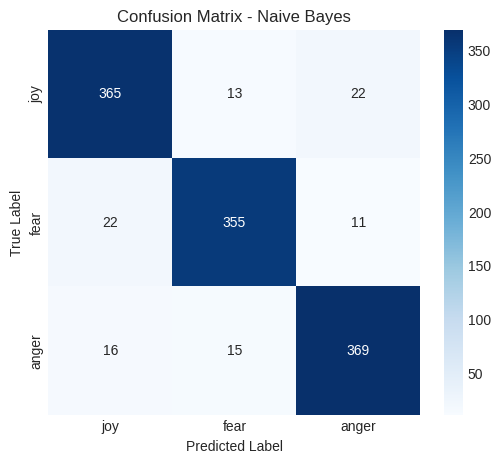

--- Evaluasi Model: SVM ---
Accuracy: 0.9217
Precision: 0.9230
Recall: 0.9217
F1-Score: 0.9217
Inference Time: 1.4224 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.89      0.96      0.92       400
        fear       0.95      0.90      0.92       388
       anger       0.93      0.91      0.92       400

    accuracy                           0.92      1188
   macro avg       0.92      0.92      0.92      1188
weighted avg       0.92      0.92      0.92      1188



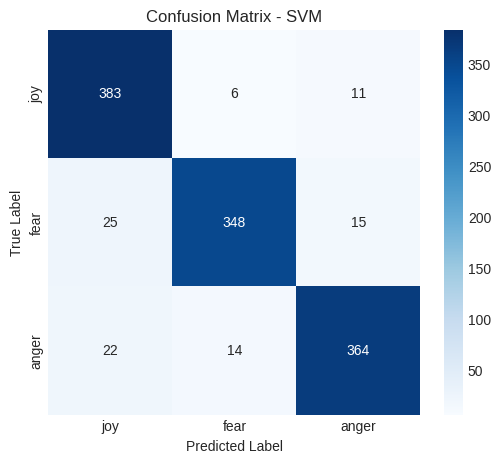

--- Evaluasi Model: Random Forest ---
Accuracy: 0.9386
Precision: 0.9391
Recall: 0.9386
F1-Score: 0.9386
Inference Time: 0.1463 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.97      0.93      0.95       400
        fear       0.92      0.96      0.94       388
       anger       0.93      0.93      0.93       400

    accuracy                           0.94      1188
   macro avg       0.94      0.94      0.94      1188
weighted avg       0.94      0.94      0.94      1188



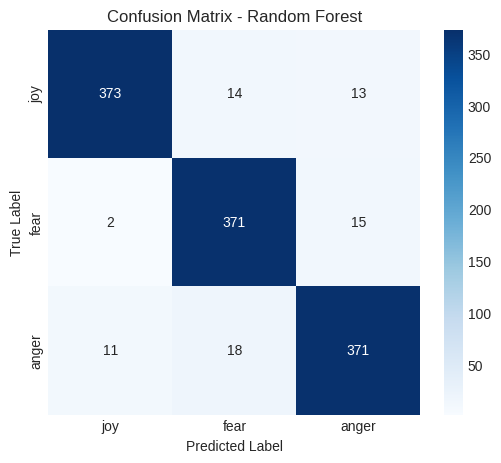


Memulai Training Deep Learning Models...



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
  2/149 ━━━━━━━━━━━━━━━━━━━━ 1:36 656ms/step - accuracy: 0.4375 - loss: 1.0991

In [ ]:
# ==============================================================================
# 1. IMPORT LIBRARIES
# ==============================================================================
import numpy as np
import pandas as pd
import time
import re
from unicodedata import normalize
import warnings

# NLTK for preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from torch.optim import AdamW

# TensorFlow / Keras for Deep Learning (BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# PyTorch & Transformers for Deep Learning (BERT, RoBERTa, DistilBERT)
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    logging as hf_logging
)

# ==============================================================================
# INITIAL SETUP
# ==============================================================================
# Suppress warnings
warnings.filterwarnings('ignore')
hf_logging.set_verbosity_error() # Suppress transformers warnings

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")


# Download NLTK data (only need to run once)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    print("Download complete.")

# ==============================================================================
# 2. DATA LOADING & PREPROCESSING
# ==============================================================================
# Load dataset
try:
    df = pd.read_csv('Emotion_classify_Data.csv')
except FileNotFoundError:
    print("Pastikan file 'Emotion_classify_Data.csv' berada di direktori yang sama.")
    # Create a dummy dataframe for demonstration if file not found
    data = {'Comment': ["I am so happy and joyful today!",
                        "This is a very scary movie, I am afraid.",
                        "I am so angry at him for what he did.",
                        "i feel so good and amazing",
                        "this is horrible i hate it so much"],
            'Emotion': ['joy', 'fear', 'anger', 'joy', 'anger']}
    df = pd.DataFrame(data)
    df.columns = [c.lower() for c in df.columns]

# Your provided preprocessing function
def preprocessing(text: str) -> str:
    """
    This function takes raw text as input and performs a series of preprocessing steps.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w != 'rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# --- DEBUG: Show data before preprocessing ---
print("="*50)
print("Data SEBELUM Preprocessing:")
print("="*50)
print(df.head())
print("\n" * 2)

# Apply preprocessing
df['preprocessed_comment'] = df['Comment'].apply(preprocessing)

# --- DEBUG: Show data after preprocessing ---
print("="*50)
print("Data SETELAH Preprocessing:")
print("="*50)
print(df[['Comment', 'preprocessed_comment']].head())
print("\n" * 2)

# Encode labels
emotion_map = {'joy': 0, 'fear': 1, 'anger': 2}
df['label'] = df['Emotion'].map(emotion_map)
id2label = {v: k for k, v in emotion_map.items()}
num_labels = len(emotion_map)

# ==============================================================================
# 3. DATA SPLITTING & DISTRIBUTION CHECK
# ==============================================================================
X = df['preprocessed_comment']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- DEBUG: Show emotion distribution after splitting ---
print("="*50)
print("Distribusi Emosi Setelah Splitting (80:20):")
print("="*50)
print("\nDistribusi Data Training:")
print(y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\nDistribusi Data Testing:")
print(y_test.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\n" * 2)

# Store all model results for final comparison
results = {}

# Helper function for evaluation
def evaluate_model(name, y_true, y_pred, y_prob, inference_time, history=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Inference Time (s)': inference_time
    }

    print(f"--- Evaluasi Model: {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_map.keys()))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot Training History for Deep Learning models
    if history:
        pd.DataFrame(history.history).plot(figsize=(10, 6))
        plt.grid(True)
        plt.gca().set_ylim(0, 1.1)
        plt.title(f'Training & Validation Metrics - {name}')
        plt.show()

# ==============================================================================
# 4. MACHINE LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Machine Learning Models...")
print("="*50 + "\n")

#  --- Feature Extraction: TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# ####################################################################
# ## BLOK DEBUG BARU ##
# ####################################################################
print("\n" + "="*50)
print("DEBUG: HASIL EKSTRAKSI FITUR TF-IDF")
print("="*50)

# 1. Tampilkan Teks SEBELUM Ekstraksi (Contoh 1 data dari set pelatihan)
print("\n--- Teks SEBELUM di-vektorisasi (1 sampel) ---")
sample_text_before = X_train.iloc[0]
print(f"Teks: '{sample_text_before}'")

# 2. Tampilkan Informasi Matriks SESUDAH Ekstraksi
print("\n--- Informasi Matriks SESUDAH di-vektorisasi ---")
print(f"Bentuk (shape) dari matriks TF-IDF (data latih): {X_train_tfidf.shape}")
print(f"Artinya: {X_train_tfidf.shape[0]} dokumen dan {X_train_tfidf.shape[1]} fitur (kata/n-gram).")

# 3. Tampilkan Vektor TF-IDF untuk satu dokumen
print("\n--- Contoh Vektor TF-IDF untuk Sampel Teks di Atas ---")
# Dapatkan nama fitur (kosakata) dari vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
# Ubah baris pertama dari matriks sparse menjadi array padat
vector_after = X_train_tfidf[0].toarray()[0]
# Buat DataFrame untuk visualisasi
df_tfidf_sample = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': vector_after})
# Tampilkan hanya term yang memiliki skor > 0 untuk sampel tersebut
print("Term dan Skor TF-IDF yang ada pada sampel (selain 0):")
print(df_tfidf_sample[df_tfidf_sample['TF-IDF Score'] > 0].to_string(index=False))

print("\n" + "="*50)

# --- Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_nb = nb_model.predict(X_test_tfidf)
y_prob_nb = nb_model.predict_proba(X_test_tfidf)
inference_time_nb = time.time() - start_time
evaluate_model('Naive Bayes', y_test, y_pred_nb, y_prob_nb, inference_time_nb)

# --- SVM ---
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_svm = svm_model.predict(X_test_tfidf)
y_prob_svm = svm_model.predict_proba(X_test_tfidf)
inference_time_svm = time.time() - start_time
evaluate_model('SVM', y_test, y_pred_svm, y_prob_svm, inference_time_svm)

# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)
inference_time_rf = time.time() - start_time
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf, inference_time_rf)


# ==============================================================================
# 5. DEEP LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Deep Learning Models...")
print("="*50 + "\n")

# --- BiLSTM ---
# Hyperparameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
MAX_LEN = 128
EPOCHS_BILSTM = 20
LR_BILSTM = 1e-3

# Tokenization and Padding
tokenizer_keras = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_keras.fit_on_texts(X_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Model Definition
bilstm_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

bilstm_model.compile(
    optimizer=Adam(learning_rate=LR_BILSTM),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(bilstm_model.summary())

history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_BILSTM,
    validation_data=(X_test_pad, y_test),
    batch_size=32,
    verbose=1
)

start_time = time.time()
y_prob_bilstm = bilstm_model.predict(X_test_pad)
inference_time_bilstm = time.time() - start_time
y_pred_bilstm = np.argmax(y_prob_bilstm, axis=1)
evaluate_model('BiLSTM', y_test, y_pred_bilstm, y_prob_bilstm, inference_time_bilstm, history_bilstm)


# --- TRANSFORMER MODELS (BERT, RoBERTa, DistilBERT) ---
# Hyperparameters
MAX_LEN_HF = 128
BATCH_SIZE_HF = 16
EPOCHS_HF = 10
LR_HF = 2e-5

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Models to train
transformer_models = {
    'DistilBERT': 'distilbert-base-uncased',
    'RoBERTa': 'roberta-base',
    'BERT': 'bert-base-uncased'
}

# Convert text data to list for tokenizer
X_train_list = X_train.tolist()
X_test_list = y_test.tolist()

for model_name, model_path in transformer_models.items():
    print("\n" + "-"*50)
    print(f"Training model: {model_name}")
    print("-" * 50)

    # Load Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        id2label=id2label,
        label2id=emotion_map
    ).to(device)

    # Tokenize data
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')

    # Create PyTorch Datasets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_HF, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_HF, shuffle=False)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=LR_HF)

    # Training and Validation History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_HF):
        model.train()
        total_train_loss, total_train_correct = 0, 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels).sum().item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = total_train_correct / len(train_dataset)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        total_val_loss, total_val_correct = 0, 0
        with torch.no_grad():
            for batch in test_loader:
                batch = [t.to(device) for t in batch]
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                total_val_correct += (preds == labels).sum().item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_acc = total_val_correct / len(test_dataset)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_HF} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Final Evaluation on Test Set
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time_hf = time.time() - start_time

    # Plotting custom history for transformers
    history_df = pd.DataFrame({
        'loss': history['train_loss'],
        'accuracy': history['train_acc'],
        'val_loss': history['val_loss'],
        'val_accuracy': history['val_acc'],
    })

    # Passing a dummy history object to the evaluation function
    class DummyHistory:
        def __init__(self, df):
            self.history = df.to_dict('list')

    evaluate_model(model_name, all_labels, all_preds, None, inference_time_hf, DummyHistory(history_df))

# ==============================================================================
# 6. FINAL RESULTS SUMMARY
# ==============================================================================
print("\n" + "="*50)
print("Ringkasan Hasil Semua Model")
print("="*50 + "\n")

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='F1-Score', ascending=False))

# Plotting final results for comparison
results_df.sort_values(by='F1-Score', ascending=True).plot(
    kind='barh',
    figsize=(12, 8),
    title='Perbandingan Kinerja Model',
    grid=True
)
plt.xlabel("Score")
plt.legend(loc='lower right')
plt.show()

#tanpa preprocessing

✅ Preprocessing manual diskip. Model akan menggunakan teks asli dari kolom 'Comment'.

Distribusi Emosi Setelah Splitting (80:20):

Distribusi Data Training:
label
0    33.69%
2    33.69%
1    32.62%
Name: proportion, dtype: object

Distribusi Data Testing:
label
2    33.67%
0    33.67%
1    32.66%
Name: proportion, dtype: object




Memulai Training Machine Learning Models...

--- Evaluasi Model: Naive Bayes ---
Accuracy: 0.8822
Precision: 0.8826
Recall: 0.8822
F1-Score: 0.8822
Inference Time: 0.0014 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.86      0.90      0.88       400
        fear       0.90      0.87      0.88       388
       anger       0.88      0.88      0.88       400

    accuracy                           0.88      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.88      0.88      0.88      1188



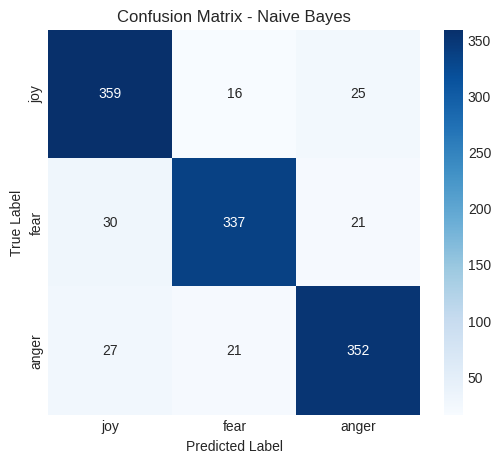

--- Evaluasi Model: SVM ---
Accuracy: 0.8965
Precision: 0.8985
Recall: 0.8965
F1-Score: 0.8966
Inference Time: 2.0644 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.85      0.93      0.89       400
        fear       0.92      0.88      0.90       388
       anger       0.93      0.88      0.90       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



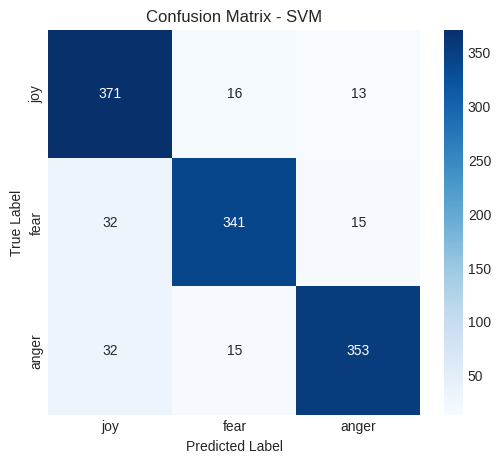

--- Evaluasi Model: Random Forest ---
Accuracy: 0.9057
Precision: 0.9076
Recall: 0.9057
F1-Score: 0.9055
Inference Time: 0.1194 seconds

Classification Report:
              precision    recall  f1-score   support

         joy       0.87      0.95      0.91       400
        fear       0.91      0.90      0.91       388
       anger       0.94      0.86      0.90       400

    accuracy                           0.91      1188
   macro avg       0.91      0.91      0.91      1188
weighted avg       0.91      0.91      0.91      1188



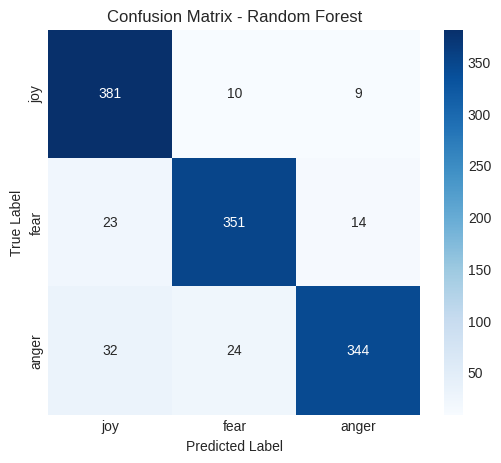


Memulai Training Deep Learning Models...



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.3778 - loss: 1.0802 - val_accuracy: 0.7391 - val_loss: 0.6358
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8963 - loss: 0.3102 - val_accuracy: 0.9259 - val_loss: 0.2230
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9654 - loss: 0.1231 - val_accuracy: 0.9259 - val_loss: 0.2283
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9856 - loss: 0.0421 - val_accuracy: 0.9158 - val_loss: 0.3168
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9950 - loss: 0.0198 - val_accuracy: 0.9352 - val_loss: 0.2615
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9962 - loss: 0.0152 - val_accuracy: 0.9049 - val_loss: 0.3944
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9890 - loss: 0.0307 - val_accuracy: 0.9276 - val_loss: 0.2707
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9945 - loss: 0.0142 - va

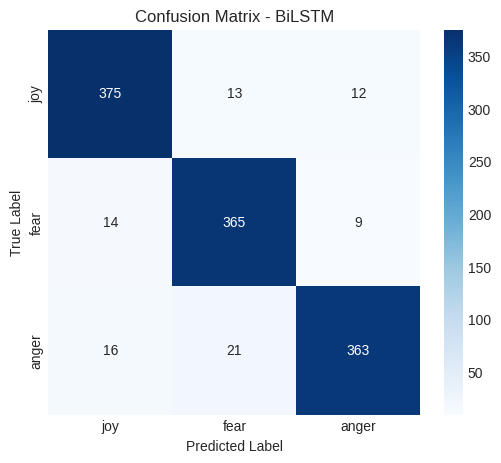

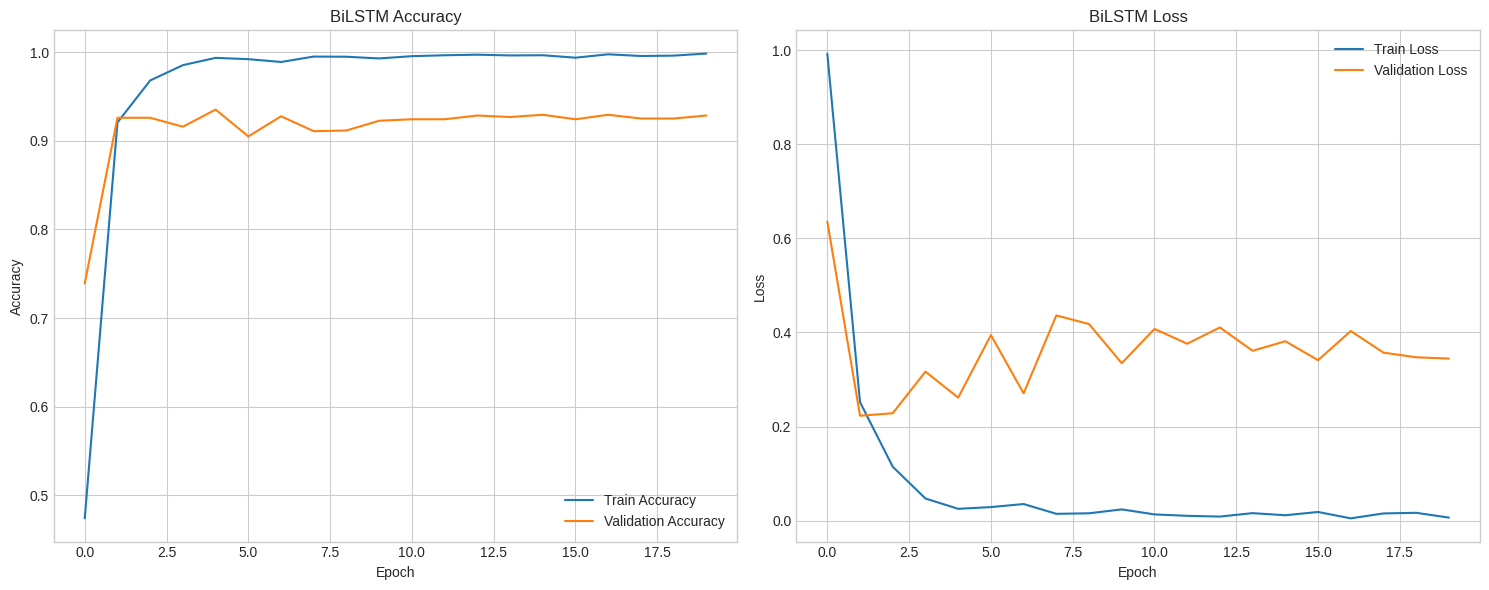

Using device: cuda

--------------------------------------------------
Training model: DistilBERT
--------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.3962 | Train Acc: 0.8360 | Val Loss: 0.1370 | Val Acc: 0.9554
Epoch 2/10 | Train Loss: 0.0788 | Train Acc: 0.9730 | Val Loss: 0.1090 | Val Acc: 0.9613
Epoch 3/10 | Train Loss: 0.0428 | Train Acc: 0.9844 | Val Loss: 0.0960 | Val Acc: 0.9663
Epoch 4/10 | Train Loss: 0.0243 | Train Acc: 0.9907 | Val Loss: 0.1668 | Val Acc: 0.9571
Epoch 5/10 | Train Loss: 0.0297 | Train Acc: 0.9912 | Val Loss: 0.1104 | Val Acc: 0.9714
Epoch 6/10 | Train Loss: 0.0237 | Train Acc: 0.9920 | Val Loss: 0.1099 | Val Acc: 0.9697
Epoch 7/10 | Train Loss: 0.0213 | Train Acc: 0.9933 | Val Loss: 0.1347 | Val Acc: 0.9646
Epoch 8/10 | Train Loss: 0.0164 | Train Acc: 0.9947 | Val Loss: 0.1647 | Val Acc: 0.9621
Epoch 9/10 | Train Loss: 0.0202 | Train Acc: 0.9933 | Val Loss: 0.1190 | Val Acc: 0.9672
Epoch 10/10 | Train Loss: 0.0090 | Train Acc: 0.9973 | Val Loss: 0.1527 | Val Acc: 0.9663
--- Evaluasi Model: DistilBERT ---
Accuracy: 0.9663
Precision: 0.9668
Recall: 0.9663
F1-Score: 0.9664
Inferen

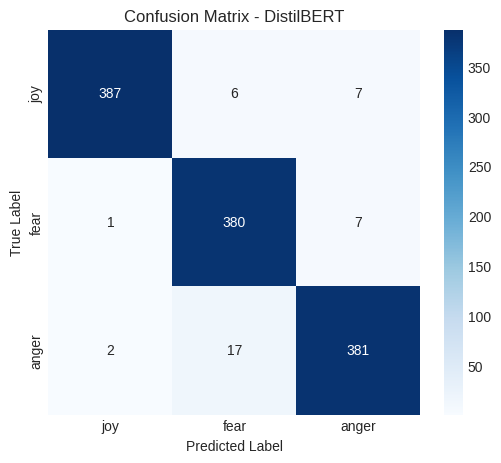

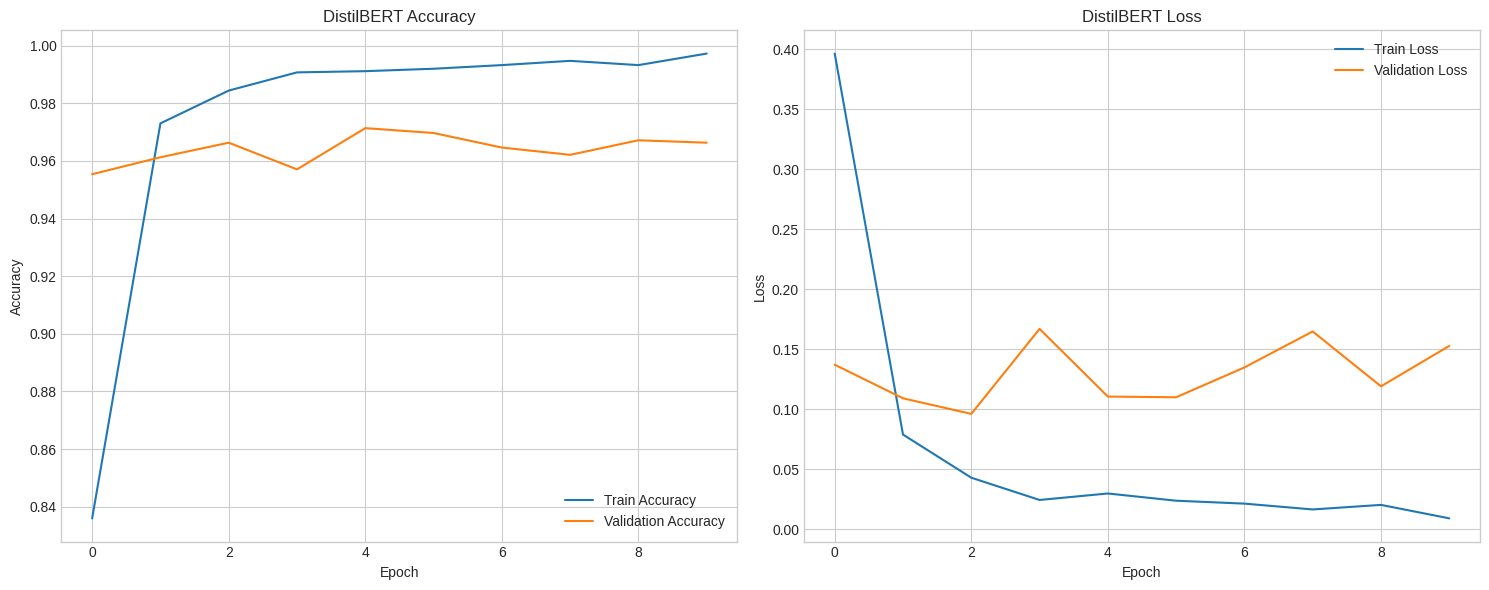


--------------------------------------------------
Training model: RoBERTa
--------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.3847 | Train Acc: 0.8383 | Val Loss: 0.1406 | Val Acc: 0.9554
Epoch 2/10 | Train Loss: 0.0955 | Train Acc: 0.9640 | Val Loss: 0.1223 | Val Acc: 0.9537
Epoch 3/10 | Train Loss: 0.0628 | Train Acc: 0.9762 | Val Loss: 0.1381 | Val Acc: 0.9537
Epoch 4/10 | Train Loss: 0.0459 | Train Acc: 0.9817 | Val Loss: 0.1086 | Val Acc: 0.9596
Epoch 5/10 | Train Loss: 0.0358 | Train Acc: 0.9838 | Val Loss: 0.1393 | Val Acc: 0.9604
Epoch 6/10 | Train Loss: 0.0347 | Train Acc: 0.9838 | Val Loss: 0.1374 | Val Acc: 0.9604
Epoch 7/10 | Train Loss: 0.0389 | Train Acc: 0.9827 | Val Loss: 0.1265 | Val Acc: 0.9638
Epoch 8/10 | Train Loss: 0.0314 | Train Acc: 0.9882 | Val Loss: 0.1145 | Val Acc: 0.9697
Epoch 9/10 | Train Loss: 0.0264 | Train Acc: 0.9891 | Val Loss: 0.1362 | Val Acc: 0.9722
Epoch 10/10 | Train Loss: 0.0247 | Train Acc: 0.9899 | Val Loss: 0.1501 | Val Acc: 0.9621
--- Evaluasi Model: RoBERTa ---
Accuracy: 0.9621
Precision: 0.9631
Recall: 0.9621
F1-Score: 0.9619
Inference 

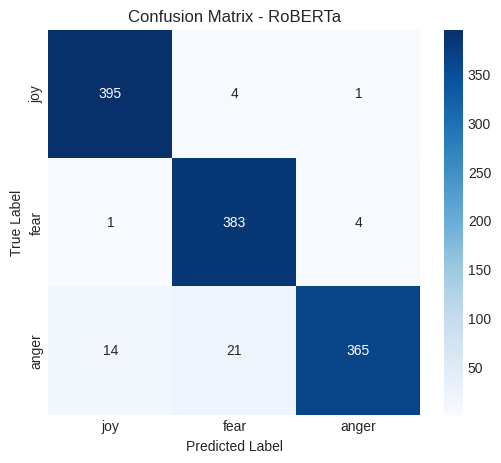

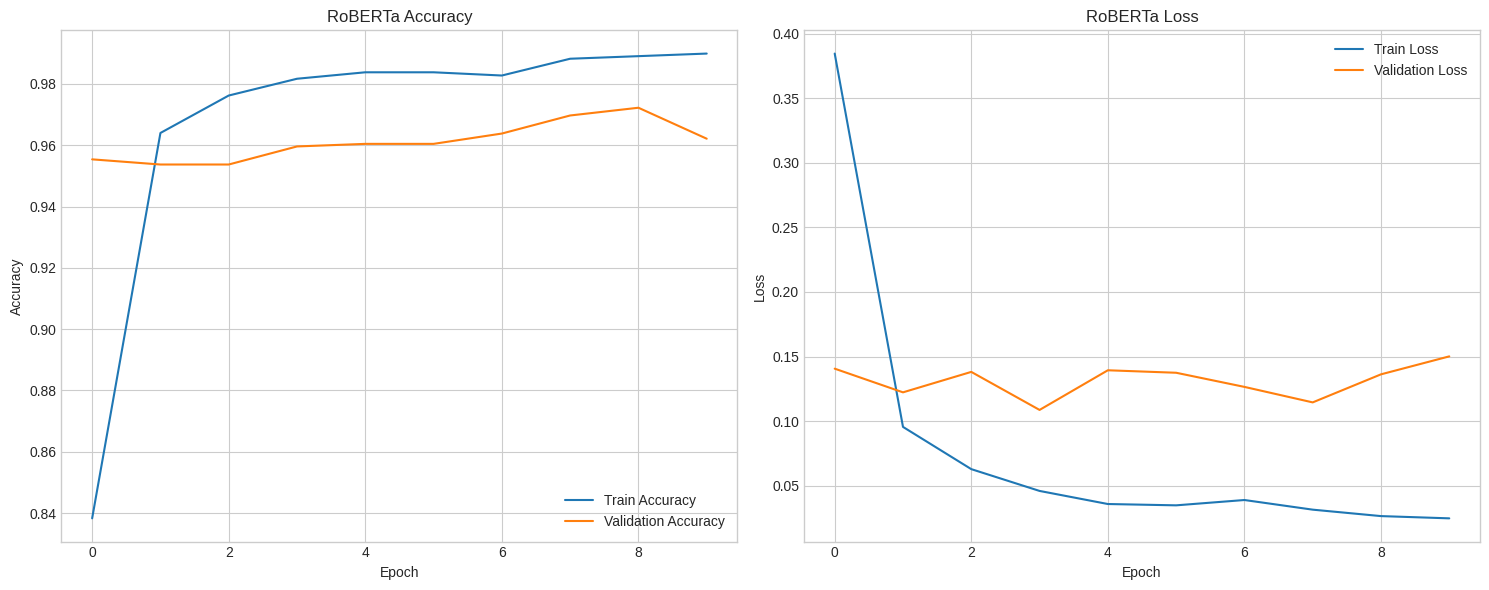


--------------------------------------------------
Training model: BERT
--------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.3750 | Train Acc: 0.8499 | Val Loss: 0.1738 | Val Acc: 0.9411
Epoch 2/10 | Train Loss: 0.0795 | Train Acc: 0.9709 | Val Loss: 0.1141 | Val Acc: 0.9596
Epoch 3/10 | Train Loss: 0.0458 | Train Acc: 0.9836 | Val Loss: 0.1362 | Val Acc: 0.9529
Epoch 4/10 | Train Loss: 0.0254 | Train Acc: 0.9903 | Val Loss: 0.1692 | Val Acc: 0.9520
Epoch 5/10 | Train Loss: 0.0325 | Train Acc: 0.9882 | Val Loss: 0.1368 | Val Acc: 0.9571
Epoch 6/10 | Train Loss: 0.0172 | Train Acc: 0.9939 | Val Loss: 0.1426 | Val Acc: 0.9663
Epoch 7/10 | Train Loss: 0.0158 | Train Acc: 0.9945 | Val Loss: 0.1335 | Val Acc: 0.9714
Epoch 8/10 | Train Loss: 0.0113 | Train Acc: 0.9956 | Val Loss: 0.1439 | Val Acc: 0.9697
Epoch 9/10 | Train Loss: 0.0067 | Train Acc: 0.9977 | Val Loss: 0.1797 | Val Acc: 0.9613
Epoch 10/10 | Train Loss: 0.0183 | Train Acc: 0.9941 | Val Loss: 0.1324 | Val Acc: 0.9722
--- Evaluasi Model: BERT ---
Accuracy: 0.9722
Precision: 0.9733
Recall: 0.9722
F1-Score: 0.9723
Inference Tim

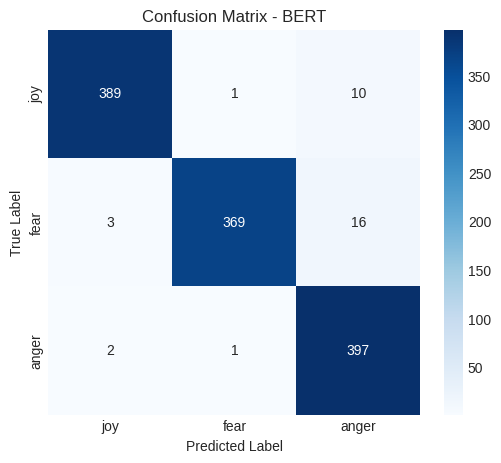

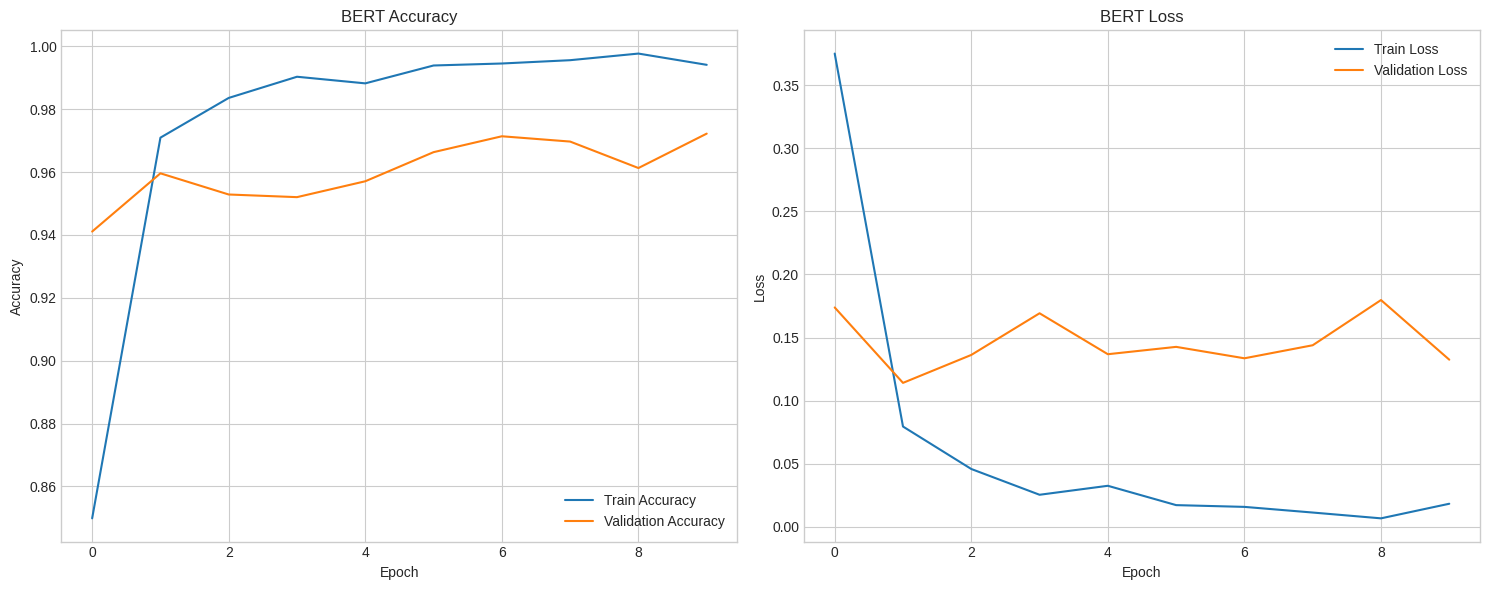


Ringkasan Hasil Semua Model

               Accuracy  Precision    Recall  F1-Score  Inference Time (s)
BERT           0.972222   0.973271  0.972222  0.972314            4.738864
DistilBERT     0.966330   0.966837  0.966330  0.966405            2.374424
RoBERTa        0.962121   0.963119  0.962121  0.961886            4.445372
BiLSTM         0.928451   0.928815  0.928451  0.928432            1.001519
Random Forest  0.905724   0.907583  0.905724  0.905519            0.119358
SVM            0.896465   0.898501  0.896465  0.896646            2.064401
Naive Bayes    0.882155   0.882640  0.882155  0.882184            0.001402


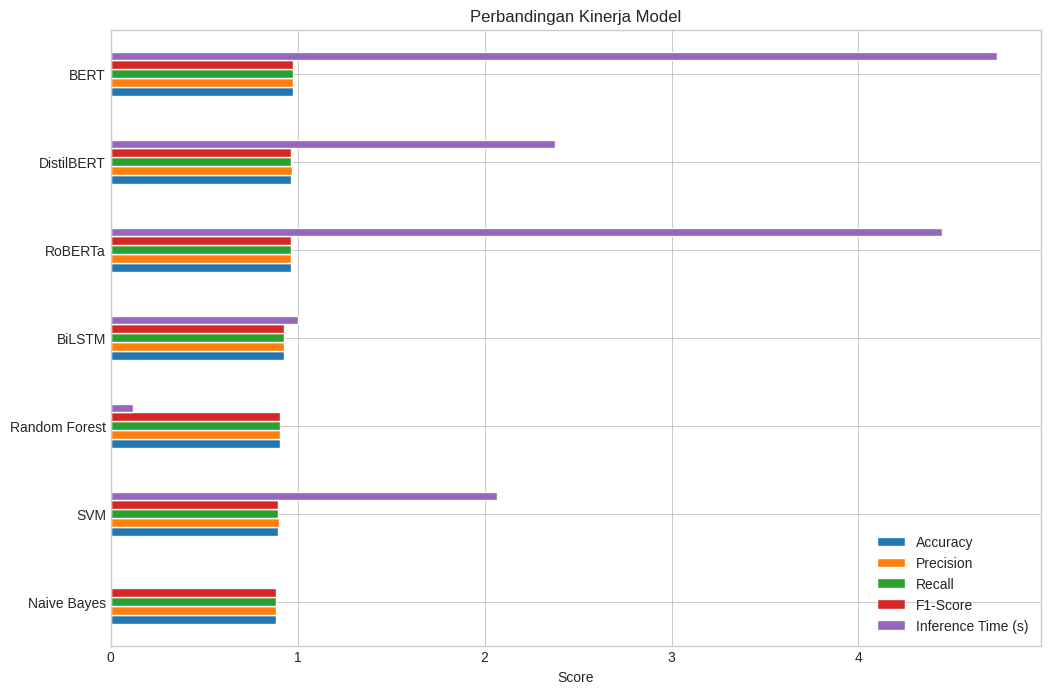

In [ ]:
# ==============================================================================
# 1. IMPORT LIBRARIES
# ==============================================================================
import numpy as np
import pandas as pd
import time
import re
from unicodedata import normalize
import warnings

# NLTK for preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from torch.optim import AdamW

# TensorFlow / Keras for Deep Learning (BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# PyTorch & Transformers for Deep Learning (BERT, RoBERTa, DistilBERT)
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    logging as hf_logging
)

# ==============================================================================
# INITIAL SETUP
# ==============================================================================
# Suppress warnings
warnings.filterwarnings('ignore')
hf_logging.set_verbosity_error() # Suppress transformers warnings

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")


# Download NLTK data (only need to run once)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    print("Download complete.")

# ==============================================================================
# 2. DATA LOADING & PREPROCESSING
# ==============================================================================
# Load dataset
try:
    df = pd.read_csv('Emotion_classify_Data.csv')
except FileNotFoundError:
    print("Pastikan file 'Emotion_classify_Data.csv' berada di direktori yang sama.")
    # Create a dummy dataframe for demonstration if file not found
    data = {'Comment': ["I am so happy and joyful today!",
                        "This is a very scary movie, I am afraid.",
                        "I am so angry at him for what he did.",
                        "i feel so good and amazing",
                        "this is horrible i hate it so much"],
            'Emotion': ['joy', 'fear', 'anger', 'joy', 'anger']}
    df = pd.DataFrame(data)
    df.columns = [c.lower() for c in df.columns]

# Fungsi preprocessing manual (disimpan sebagai referensi, tapi tidak digunakan)
def preprocessing(text: str) -> str:
    """
    This function takes raw text as input and performs a series of preprocessing steps.
    """
    # (Isi fungsi ini tidak diubah, hanya panggilannya yang dihilangkan)
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w != 'rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)


# --- DIKOMENTARI: Langkah preprocessing manual diskip ---
# print("="*50)
# print("Data SEBELUM Preprocessing:")
# print("="*50)
# print(df.head())
# print("\n" * 2)
#
# # Apply preprocessing
# df['preprocessed_comment'] = df['Comment'].apply(preprocessing)
#
# # --- DEBUG: Show data after preprocessing ---
# print("="*50)
# print("Data SETELAH Preprocessing:")
# print("="*50)
# print(df[['Comment', 'preprocessed_comment']].head())
# print("\n" * 2)
print("✅ Preprocessing manual diskip. Model akan menggunakan teks asli dari kolom 'Comment'.\n")


# Encode labels
emotion_map = {'joy': 0, 'fear': 1, 'anger': 2}
df['label'] = df['Emotion'].map(emotion_map)
id2label = {v: k for k, v in emotion_map.items()}
num_labels = len(emotion_map)

# ==============================================================================
# 3. DATA SPLITTING & DISTRIBUTION CHECK
# ==============================================================================
# DIUBAH: Menggunakan kolom 'Comment' (teks asli) sebagai input (X)
X = df['Comment']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- DEBUG: Show emotion distribution after splitting ---
print("="*50)
print("Distribusi Emosi Setelah Splitting (80:20):")
print("="*50)
print("\nDistribusi Data Training:")
print(y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\nDistribusi Data Testing:")
print(y_test.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("\n" * 2)

# Store all model results for final comparison
results = {}

# Helper function for evaluation (Tidak diubah)
def evaluate_model(name, y_true, y_pred, y_prob, inference_time, history=None):
    """
    Mengevaluasi model, menampilkan metrik, dan memvisualisasikan hasil.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Inference Time (s)': inference_time
    }

    print(f"--- Evaluasi Model: {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_map.keys()))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    if history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(history.history['accuracy'], label='Train Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{name} Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend(loc='lower right')
        ax1.grid(True)
        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{name} Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend(loc='upper right')
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

# ==============================================================================
# 4. MACHINE LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Machine Learning Models...")
print("="*50 + "\n")

# --- Feature Extraction: TF-IDF ---
# X_train dan X_test sekarang berisi teks asli
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_nb = nb_model.predict(X_test_tfidf)
y_prob_nb = nb_model.predict_proba(X_test_tfidf)
inference_time_nb = time.time() - start_time
evaluate_model('Naive Bayes', y_test, y_pred_nb, y_prob_nb, inference_time_nb)

# --- SVM ---
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_svm = svm_model.predict(X_test_tfidf)
y_prob_svm = svm_model.predict_proba(X_test_tfidf)
inference_time_svm = time.time() - start_time
evaluate_model('SVM', y_test, y_pred_svm, y_prob_svm, inference_time_svm)

# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)
inference_time_rf = time.time() - start_time
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf, inference_time_rf)


# ==============================================================================
# 5. DEEP LEARNING MODELS
# ==============================================================================
print("\n" + "="*50)
print("Memulai Training Deep Learning Models...")
print("="*50 + "\n")

# --- BiLSTM ---
# Hyperparameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
MAX_LEN = 128
EPOCHS_BILSTM = 20
LR_BILSTM = 1e-3

# Tokenization and Padding (pada teks asli di X_train & X_test)
tokenizer_keras = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_keras.fit_on_texts(X_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Model Definition (Tidak diubah)
bilstm_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax')
])
bilstm_model.compile(
    optimizer=Adam(learning_rate=LR_BILSTM),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(bilstm_model.summary())

# Training (Tidak diubah)
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_BILSTM,
    validation_data=(X_test_pad, y_test),
    batch_size=32,
    verbose=1
)
start_time = time.time()
y_prob_bilstm = bilstm_model.predict(X_test_pad)
inference_time_bilstm = time.time() - start_time
y_pred_bilstm = np.argmax(y_prob_bilstm, axis=1)
evaluate_model('BiLSTM', y_test, y_pred_bilstm, y_prob_bilstm, inference_time_bilstm, history_bilstm)


# --- TRANSFORMER MODELS (BERT, RoBERTa, DistilBERT) ---
# Hyperparameters
MAX_LEN_HF = 128
BATCH_SIZE_HF = 16
EPOCHS_HF = 10
LR_HF = 2e-5

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Models to train
transformer_models = {
    'DistilBERT': 'distilbert-base-uncased',
    'RoBERTa': 'roberta-base',
    'BERT': 'bert-base-uncased'
}

# X_train dan X_test sekarang berisi teks asli
for model_name, model_path in transformer_models.items():
    print("\n" + "-"*50)
    print(f"Training model: {model_name}")
    print("-" * 50)

    # Load Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        id2label=id2label,
        label2id=emotion_map
    ).to(device)

    # Tokenize data
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LEN_HF, return_tensors='pt')

    # Create PyTorch Datasets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

    # ... (Sisa dari loop training dan evaluasi Transformer tidak diubah) ...
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_HF, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_HF, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=LR_HF)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_HF):
        model.train()
        total_train_loss, total_train_correct = 0, 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels).sum().item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = total_train_correct / len(train_dataset)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        total_val_loss, total_val_correct = 0, 0
        with torch.no_grad():
            for batch in test_loader:
                batch = [t.to(device) for t in batch]
                input_ids, attention_mask, labels = batch
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                total_val_correct += (preds == labels).sum().item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_acc = total_val_correct / len(test_dataset)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{EPOCHS_HF} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time_hf = time.time() - start_time

    history_df = pd.DataFrame({
        'loss': history['train_loss'], 'accuracy': history['train_acc'],
        'val_loss': history['val_loss'], 'val_accuracy': history['val_acc'],
    })
    class DummyHistory:
        def __init__(self, df):
            self.history = df.to_dict('list')
    evaluate_model(model_name, all_labels, all_preds, None, inference_time_hf, DummyHistory(history_df))

# ==============================================================================
# 6. FINAL RESULTS SUMMARY
# ==============================================================================
print("\n" + "="*50)
print("Ringkasan Hasil Semua Model")
print("="*50 + "\n")

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='F1-Score', ascending=False))

# Plotting final results for comparison
results_df.sort_values(by='F1-Score', ascending=True).plot(
    kind='barh',
    figsize=(12, 8),
    title='Perbandingan Kinerja Model',
    grid=True
)
plt.xlabel("Score")
plt.legend(loc='lower right')
plt.show()